# High Energy Code

In this notebook, we demonstrate how the high energy code works and run some cross checks. 

## Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [31]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import pickle
import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
from darkhistory.spec.spectrum import Spectrum
import darkhistory.history.tla as tla

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

np.set_printoptions(threshold=np.nan)

## Reference Data

In [3]:
mwimp = 1e12
neng = 500
dlneng = np.log(mwimp)/neng
elecbins = np.exp(np.arange(neng+1)*dlneng)
englow = elecbins[0:neng]
enghigh = elecbins[1:]
eleceng_ref = np.sqrt(englow*enghigh)

nphoteng = 500
dlnphoteng = np.log(mwimp/1e-2)/nphoteng
photenglow = 1e-2*np.exp(np.arange(nphoteng)*dlnphoteng)
photenghigh = 1e-2*np.exp((np.arange(nphoteng)+1)*dlnphoteng)
photeng_ref = np.sqrt(photenglow*photenghigh)

ICS_test_filename = "/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_test.fits"
ICS_test = fits.open(ICS_test_filename)
ICS_test_spec = ICS_test[0].data
ICS_test_spec = np.transpose(ICS_test_spec)
ICS_test_list_spec = [Spectrum(photeng_ref, arr, in_eng=in_eng) for (arr, in_eng) in zip(ICS_test_spec, eleceng_ref)]
ICS_test_tf = tf.TransFuncAtRedshift(ICS_test_list_spec, dlnz=-1)

## Inputs

The inputs of the code are as follows: 

1. A `Spectrum` or `Spectra` object containing the injected electron spectrum, or the injected electron spectrum as a function of redshift, and/or 

2. A `Spectrum` or `Spectra` object containing the injected photon spectrum, or the injected photon spectrum as a function of redshift.

There are 3 modes of use. For a `Spectrum` input, the spectrum can be interpreted either as a single injection at a particular redshift, and no subsequent injections, or as a spectrum with the redshift dependence factored out, with a continuous injection at every step. For a `Spectra` input, the spectrum at each redshift step is injected. 

We will start with the single injection case here. As an example, we begin with a $\delta$-function injection of two 1 MeV electrons at some arbitrary energy, start at redshift $1+z = 2000$. Let's first initialize the spectrum. 

In [17]:
eleceng = np.logspace(1, 13, 100)
photeng = np.logspace(-4, 13, 100)
eleceng = eleceng
photeng = photeng

rs = 1000

elec_spec_init = spectools.rebin_N_arr(np.array([1]), 
                                      np.array([1e11]),
                                      eleceng)

elec_spec_init.rs = rs

## Resolved Injected Electrons

High energy electrons ($\gg$ keV) primarily cool by inverse compton scattering (ICS), at a rate that is much faster than the smallest timestep allowable in this code ($\Delta \log (1+z) = 10^{-3}$). Lower energy electrons also cool quickly, but via atomic processes.

Low energy electrons ($< 3.5$ keV) are read out immediately and saved in a `Spectra` object. High energy electrons will be converted into a photon spectrum through ICS, and an estimate for the energy loss due to atomic cooling also produced. 

For now, we will assume only ICS for high energy electrons. 

In [18]:
user="hongwan"
raw_nonrel_ICS_tf = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))
raw_rel_ICS_tf = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))
raw_engloss_tf = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))

(ics_phot_tf, ics_lowengelec_tf) = get_ics_cooling_tf(raw_nonrel_ICS_tf,
                                                     raw_rel_ICS_tf,
                                                     raw_engloss_tf,
                                                     eleceng, photeng, rs)

Check that the result makes sense, relative to the reference data. In order to ensure an exact comparison, Be sure to use exactly the same electron and photon energy abscissa, as well as a redshift of 1000. The abscissa of the reference data is:

```python
mwimp = 1e12
neng = 500
dlneng = np.log(mwimp)/neng
elecbins = np.exp(np.arange(neng+1)*dlneng)
englow = elecbins[0:neng]
enghigh = elecbins[1:]
eleceng_ref = np.sqrt(englow*enghigh)

nphoteng = 500
dlnphoteng = np.log(mwimp/1e-2)/nphoteng
photenglow = 1e-2*np.exp(np.arange(nphoteng)*dlnphoteng)
photenghigh = 1e-2*np.exp((np.arange(nphoteng)+1)*dlnphoteng)
photeng_ref = np.sqrt(photenglow*photenghigh)
```

[0.0001, 10000000000000.0, 1e-16, 10000000000.0]

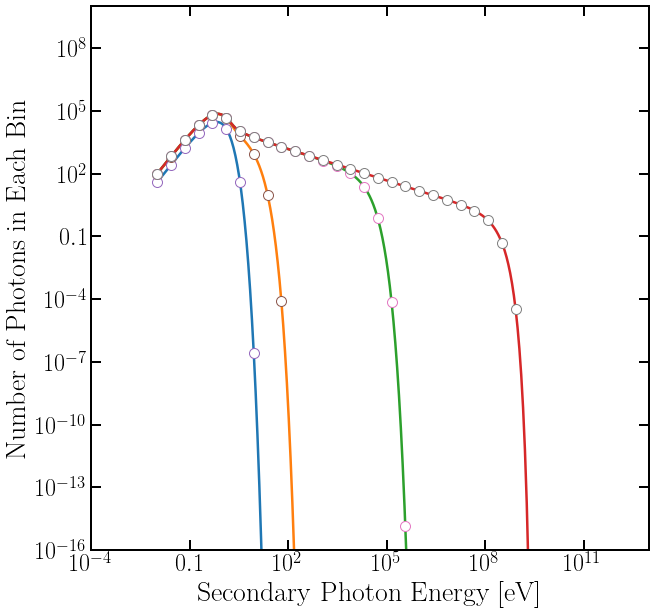

In [91]:
# plt.figure()

# ax = plt.gca()
# comp_elec_kineng = np.array([3.5e3, 5e5, 5e7, 5e9])
# ics_phot_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng')
# ICS_test_tf.plot(
#     ax, ind=comp_elec_kineng, indtype='in_eng', 
#     linewidth=0, marker='o', markersize='10', 
#     markerfacecolor='w', markevery=15,
# )

# ax.set_xscale('log')
# ax.set_yscale('log')

# plt.xlabel('Secondary Photon Energy [eV]')
# plt.ylabel('Number of Photons in Each Bin')
# plt.axis([1e-4, 1e13, 1e-16, 1e10])


Now, scatter the initial photons through the full ICS transfer function.

In [19]:
phot_spec_init = spectools.scatter(ics_phot_tf, elec_spec_init, new_eng=photeng)

## Photon Cooling

Now we cool the photons that result from the high energy electron injection. Photons below 3.1 keV are considered low energy photons. For high energy photons, greater than 3.1 keV, we have transfer functions (a function of *both* injected photon energy and redshift, so they are given as a `TransFuncList`), into high energy photons, low energy photons and low energy electrons. Let's load them first.

In [50]:
highengphot_tflist = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_photspec.raw", "rb"))
lowengphot_tflist  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec.raw", "rb"))
lowengelec_tflist  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec.raw", "rb"))

# This is a list of mwimp values used to generate highengphot_tflist
mwimp_arr = np.array(highengphot_tflist.in_eng)

# This shouldn't be necessary. There is one negative value somewhere. Check.
for tf in highengphot_tflist:
    tf.grid_vals[np.where(tf.grid_vals < 0)] = 0
for tf in lowengphot_tflist:
    tf.grid_vals[np.where(tf.grid_vals < 0)] = 0

We now need to construct a transfer function list for *both* high- and low-energy photons. It needs to be a square matrix (so that we can take powers of the matrix for coarsening later), with dimensions given by the length of `photeng`.

In [51]:
#Split photeng into high and low energy. 
photeng_high = photeng[photeng > 3070]
photeng_low  = photeng[photeng <= 3070]

# Split eleceng into high and low energy. 
eleceng_high = eleceng[eleceng > 3500]
eleceng_low  = eleceng[eleceng <= 3500]

# highengphot_tflist.in_eng set to photeng_high
highengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
for tf in highengphot_tflist:
    tf.rebin(photeng_high)
    # Pad with zeros so that it becomes photeng x photeng. 
    tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size, 0), (photeng_low.size, 0)), 'constant')
    tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
    tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
    tf._in_eng = photeng
    tf._eng = photeng
highengphot_tflist.eng = photeng
highengphot_tflist.in_eng = photeng
    
# lowengphot_tflist.in_eng set to photeng_high
lowengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
for tf in lowengphot_tflist:
    tf.rebin(photeng)
    # Pad with zeros so that it becomes photeng x photeng. 
    tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
    tf._in_eng = photeng
    tf._eng = photeng
lowengphot_tflist.eng = photeng
lowengphot_tflist.in_eng = photeng
    
# lowengelec_tflist.in_eng set to photeng_high 
lowengelec_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
for tf in lowengelec_tflist:
    tf.rebin(eleceng)
    # Pad with zeros so that it becomes photeng x eleceng. 
    tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
    tf._in_eng = photeng
    tf._eng = eleceng
lowengelec_tflist.eng = eleceng
lowengelec_tflist.in_eng = photeng

We need to decide on the redshift step to use. The default redshift step in the transfer functions is $d \log (1+z) = 2 \times 10^{-3}$, with the transfer function evaluated at (currently) 50 redshifts, from $1+z = 30$ to $1+z=4$, so that the transfer function with $d \log(1+z) = 2 \times 10^{-3}$ can be interpolated between them. However, we can coarsen the high energy photon transfer function by some factor $f$ by multiplying the transfer function matrix by itself multiple times, producing transfer functions for a redshift step of $d \log (1+z) = f \times 2 \times 10^{-3}$. 

In [52]:
# The redshift step to use will be coarsen_factor * 0.002
coarsen_factor = 10
# Generate the redshifts at which we want to get an interpolated value for the transfer function. 
tf_rs_arr = highengphot_tflist.rs
rs_list = np.exp(np.arange(np.log(tf_rs_arr[0]), 
                           np.log(tf_rs_arr[-1]), 
                           -highengphot_tflist.dlnz*coarsen_factor)
                )

if coarsen_factor > 1:
    lowengphot_tflist.coarsen(coarsen_factor, delete_tfs=False, coarsen_type='dep', prop_transfunclist=highengphot_tflist)
    lowengelec_tflist.coarsen(coarsen_factor, delete_tfs=False, coarsen_type='dep', prop_transfunclist=highengphot_tflist)
    highengphot_tflist.coarsen(coarsen_factor, delete_tfs=False)
    

lowengphot_tflist.at_val('rs',rs_list)
lowengelec_tflist.at_val('rs',rs_list)
highengphot_tflist.at_val('rs',rs_list)

In [53]:
highengphot_tflist.transpose()
lowengphot_tflist.transpose()
lowengelec_tflist.transpose()

In [32]:
next_phot_spec = spectools.scatter(highengphot_tflist[0],phot_spec_init)
test = spectools.evolve(phot_spec_init, highengphot_tflist, evolve_type='prop', end_rs = rs_list[1])
next_low_phot_spec = spectools.scatter(lowengphot_tflist[0], phot_spec_init)
next_phot_spec = spectools.scatter(highengphot_tflist[1], next_phot_spec)
test2 = spectools.evolve(phot_spec_init, highengphot_tflist, evolve_type='prop', end_rs = rs_list[2])
next_low_phot_spec = spectools.scatter(lowengphot_tflist[0], phot_spec_init)
next_phot_spec = spectools.scatter(highengphot_tflist[2], next_phot_spec)
test3 = spectools.evolve(phot_spec_init, highengphot_tflist, evolve_type='prop', end_rs = rs_list[3])
next_low_phot_spec = spectools.scatter(lowengphot_tflist[0], phot_spec_init)

## Load Reference Results

In [37]:
eng_ind = 99

# Check that this matches with the input 

file_name = {99: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_5.328E+00_xe_1.000E-04.fits",
            199: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_7.183E+00_xe_1.000E-04.fits",
            298: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.020E+00_xe_1.000E-04.fits",
            299: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits", 
            399: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.089E+01_xe_1.000E-04.fits",
            499: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.275E+01_xe_1.000E-04.fits",
            2993: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_18_logE_9.038E+00_xe_1.000E-04.fits"}

file = fits.open(file_name[eng_ind])

file_eng = file[1].data['energy'][0,:]
file_rs = file[1].data['redshift'][0,:]
file_photonspectrum = file[1].data['photonspectrum'][0,:,:]

[0.0001, 10000000000000.0, 1e-36, 10000000000000.0]

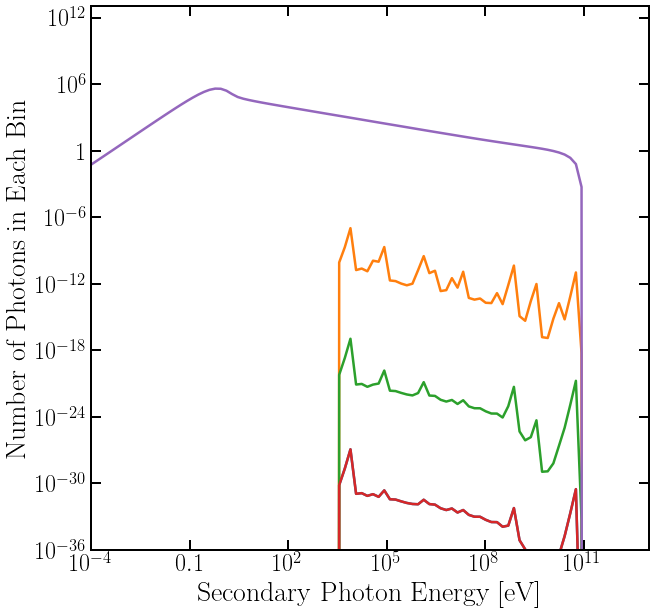

In [35]:
plt.figure()
plt.plot(next_phot_spec.eng, next_phot_spec.N)
plt.plot(test.eng, test.N)
plt.plot(test2.eng, test2.N)
plt.plot(test3.eng, test3.N)
plt.plot(phot_spec_init.eng, phot_spec_init.N)

ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e-4, 1e13, 1e-36, 1e13])